Battle of Neighbourhoods - Setting up a Restaurant in City of Los Angeles

Importing the required packages

In [58]:
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

# function to get list of venues by cateogory
import urllib

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
#!pip -q install folium
import folium
print("All Libraries Imported!")

All Libraries Imported!


Crawling wiki page and getting list of Neighbourhoods of All Los Angles uysing BeautifulSoup and storing it in pandas dataframe

In [59]:
#Get list of neighbourhoods of Los Angeles from Wikipedia
source = requests.get('https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_of_Los_Angeles').text

soup = BeautifulSoup(source, 'lxml')
links = soup.find_all("a", href=re.compile("wiki")) #extract <a> tags from html

Neighbourhoods_LA = []
for item in links:
    Neighbourhoods_LA.append(item.get('title'))

value='Yucca Corridor, Los Angeles' #set the delimiter
print(Neighbourhoods_LA.index(value))
del Neighbourhoods_LA[197:]
del Neighbourhoods_LA[0:1]

df = pd.DataFrame()
df['Neighbourhood'] = Neighbourhoods_LA
df.head()

196


,Neighbourhood
0,"Angelino Heights, Los Angeles"
1,"Arleta, Los Angeles"
2,"Arlington Heights, Los Angeles"
3,"Arts District, Los Angeles"
4,"Atwater Village, Los Angeles"


Retriving the Latitude and Longitude Coordinates and Adding it to each neghbouhood

In [60]:
def get_coords_local(NA, output_as='center'): #get the location by lat and longi when address given
    # create url
    #print(NA)
    url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search.php?q=',NA,'&format=json&polygon=0')
    output="NA"
    try:
        response = requests.get(url).json()[0]#get the response
        print(response) 
        if output_as == 'center':
            lst = [response.get(key) for key in ['lat','lon']]
            output = [float(i) for i in lst]
        #return output
        return output 
    except:
        return output    


In [ ]:
df2 = df.copy() #copy dataframe

latitude_loc = []
longitude_loc = []
for index, row in df2.iterrows():
    lat, long = get_coords_local(NA=row[0], output_as='center')#get the ncoordinates for the current row location
    latitude_loc.append(lat)
    longitude_loc.append(long)

df2['Latitude'] = latitude_loc
df2['Longitude'] = longitude_loc
df2.head()

Copy to temp dataframe for removing invalid missing data

In [61]:
df3=df2.copy() #copy to temp dataframe
df3 = df3[~df2['Latitude'].isin(['N'])] #remove neighbourhoods with missing/invalid coordinates
LACity_df=df3.copy()
LACity_df.head(15) #Coordinates for All neighbourhoods in LA 

,Neighbourhood,Latitude,Longitude
0,"Angelino Heights, Los Angeles",34.0703,-118.255
1,"Arleta, Los Angeles",34.2413,-118.432
2,"Arlington Heights, Los Angeles",34.1283,-118.156
3,"Arts District, Los Angeles",34.0412,-118.234
4,"Atwater Village, Los Angeles",34.1164,-118.256
5,"Baldwin Hills, Los Angeles",34.0076,-118.351
6,"Baldwin Hills/Crenshaw, Los Angeles",34.0124,-118.341
7,"Baldwin Village, Los Angeles",34.0195,-118.346
10,"Bel Air, Los Angeles",34.0827,-118.448
11,"Benedict Canyon, Los Angeles",34.0716,-118.418


Setup the Coordinates for relevant Los Angels Map

In [62]:
#setup coordinates of LA for folium maps
address = 'los angeles california'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The lat and longitude coordinate of LA are as follows {}, {}.'.format(latitude, longitude))

The lat and longitude coordinate of LA are as follows 34.0536834, -118.2427669.


Filtering out rest of the negihobourhoods that don't belong to Central LA

In [63]:
# Filter out neighbourhoods the belong to Central Los Angeles

neighbourhoods_names = list(LACity_df.Neighbourhood.unique())
central_LA_neightbourhoods = ['Arlington Heights, Los Angeles','Carthay, Los Angeles','Chinatown, Los Angeles','Downtown, Los Angeles','East Hollywood, Los Angeles','Echo Park, Los Angeles',
                              'Elysian Park, Los Angeles','Elysian Valley, Los Angeles','Faircrest Heights, Los Angeles','Griffith Park, Los Angeles','Hancock Park, Los Angeles','Harvard Heights, Los Angeles','Hollywood, Los Angeles',
                              'Hollywood Hills, Los Angeles','Hollywood Hills West, Los Angeles','Koreatown, Los Angeles','Larchmont, Los Angeles','Los Feliz, Los Angeles','Mid-City, Los Angeles','Mid-Wilshire, Los Angeles',
                              'Pico-Union, Los Angeles','Silver Lake, Los Angeles','Westlake, Los Angeles','Windsor Square, Los Angeles']

central_LA_neightbourhoods_df = LACity_df[LACity_df['Neighbourhood'].isin(central_LA_neightbourhoods)].reset_index(drop=True)#match the exisiting df with the Central LA df
central_LA_neightbourhoods_df_temp = central_LA_neightbourhoods_df.drop_duplicates(subset='Neighbourhood', keep="first")
central_LA_neightbourhoods_df=central_LA_neightbourhoods_df_temp.reset_index(drop=True)#drop any duplicates already exisiting
central_LA_neightbourhoods_df

,Neighbourhood,Latitude,Longitude
0,"Arlington Heights, Los Angeles",34.1283,-118.156
1,"Carthay, Los Angeles",34.0561,-118.373
2,"Chinatown, Los Angeles",34.0635,-118.236
3,"East Hollywood, Los Angeles",34.0932,-118.32
4,"Echo Park, Los Angeles",34.074,-118.261
5,"Elysian Park, Los Angeles",34.0829,-118.234
6,"Elysian Valley, Los Angeles",34.0829,-118.234
7,"Hancock Park, Los Angeles",34.0637,-118.356
8,"Harvard Heights, Los Angeles",34.0724,-118.288
9,"Hollywood Hills West, Los Angeles",34.1312,-118.336


Generating LA MAp with Central LA Neighbourhoods

In [64]:
#Show Map of the Central LA with the Neighbourhoods that will be analysed
map_LA = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(central_LA_neightbourhoods_df['Latitude'], central_LA_neightbourhoods_df['Longitude'], central_LA_neightbourhoods_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        legend_name='INeighbourhood LA Central',
        fill_opacity=0.7).add_to(map_LA)  
    
map_LA

In [65]:
#setup authentication to use foursquare apis
CLIENT_ID = 'NDRIFZQAWBYOQ5KMFOL3JWMTYHK503MWUM3LCFGHBIAAKNDA' # your Foursquare ID
CLIENT_SECRET = 'T2OQLJXALS5UEURE5FC1LRZ5ZTF2OI5LEMEHXPEIPMH5L0ZQ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NDRIFZQAWBYOQ5KMFOL3JWMTYHK503MWUM3LCFGHBIAAKNDA
CLIENT_SECRET:T2OQLJXALS5UEURE5FC1LRZ5ZTF2OI5LEMEHXPEIPMH5L0ZQ


Defining funtion to get the nearbyvenues belonging to a perticualr category

In [67]:
def getNearbyVenues(names, latitudes, longitudes, radius, categoryIdItem=''):
    try:
        LIMIT=400
        venueList=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
          
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIdItem != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIdItem)

            #set GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # get information of nearby venue by category
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venueList.append([(name,lat,lng, v['name'],v['location']['lat'], v['location']['lng'],v['categories'][0]['name'])])

        nearbyVenues = pd.DataFrame([item for venueList in venueList for item in venueList])
        nearbyVenues.columns = ['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearbyVenues)

    return(nearbyVenues)

Getting High SChools Within 2.5km of Each Neighbourhood

In [68]:
#High School Distribution in Central LA
CentralLA_Schools=getNearbyVenues(names=central_LA_neightbourhoods_df['Neighbourhood'], latitudes=central_LA_neightbourhoods_df['Latitude'],
                                  longitudes=central_LA_neightbourhoods_df['Longitude'], radius=2500, categoryIdItem='4bf58dd8d48988d13d941735')
CentralLA_Schools.head(15)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Arlington Heights, Los Angeles",34.128306,-118.156374,Westridge School For Girls,34.126522,-118.157025,High School
1,"Arlington Heights, Los Angeles",34.128306,-118.156374,Ceramics Studio,34.126276,-118.156566,High School
2,"Arlington Heights, Los Angeles",34.128306,-118.156374,Mayfield Senior School,34.130772,-118.161268,High School
3,"Arlington Heights, Los Angeles",34.128306,-118.156374,Concept Design Academy,34.140000,-118.151577,High School
4,"Arlington Heights, Los Angeles",34.128306,-118.156374,Southwestern Academy,34.115227,-118.132866,High School
5,"Arlington Heights, Los Angeles",34.128306,-118.156374,South Pasadena High School,34.109555,-118.154385,High School
6,"Arlington Heights, Los Angeles",34.128306,-118.156374,Maranatha High School,34.142343,-118.157139,High School
7,"Arlington Heights, Los Angeles",34.128306,-118.156374,Blair High School,34.126439,-118.145883,High School
8,"Arlington Heights, Los Angeles",34.128306,-118.156374,Waverly High School,34.139235,-118.152505,High School
9,"Arlington Heights, Los Angeles",34.128306,-118.156374,Brown Town,34.128102,-118.144005,High School


In [17]:
CentralLA_Schools.shape

(368, 7)

Getting Universities Within 2km of Each Neighbourhood

In [69]:
#University Distribution in Central LA
CentralLA_Universities=getNearbyVenues(names=central_LA_neightbourhoods_df['Neighbourhood'], latitudes=central_LA_neightbourhoods_df['Latitude'],
                                  longitudes=central_LA_neightbourhoods_df['Longitude'], radius=2000, categoryIdItem='4bf58dd8d48988d1ae941735')
CentralLA_Universities.head(15)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Arlington Heights, Los Angeles",34.128306,-118.156374,Art Center College Of Design South Campus,34.128910,-118.148546,College Arts Building
1,"Arlington Heights, Los Angeles",34.128306,-118.156374,The Wind Tunnel,34.129261,-118.148265,College Lab
2,"Arlington Heights, Los Angeles",34.128306,-118.156374,Art Center Graduate Art Complex,34.129150,-118.148568,University
3,"Arlington Heights, Los Angeles",34.128306,-118.156374,Los Angeles College of Music,34.139527,-118.150174,University
4,"Carthay, Los Angeles",34.056121,-118.373411,SimonMed imaging - Beverly hills,34.064295,-118.373861,Medical Center
5,"Carthay, Los Angeles",34.056121,-118.373411,Refrigerated Cell Phones,34.072632,-118.371221,University
6,"Carthay, Los Angeles",34.056121,-118.373411,Boston University in LA,34.061721,-118.353806,University
7,"Carthay, Los Angeles",34.056121,-118.373411,YULA Girls High School,34.050110,-118.385727,University
8,"Carthay, Los Angeles",34.056121,-118.373411,Career Development Institute,34.045802,-118.386151,School
9,"Chinatown, Los Angeles",34.063459,-118.236050,UCLA Paralegal Program,34.055000,-118.254590,University


Show All Schools in Central LA

In [70]:
#Show Map of the Central LA with the Neighbourhoods that will be analysed
map_LASchools = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(CentralLA_Schools['Venue Latitude'], CentralLA_Schools['Venue Longitude'], CentralLA_Schools['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_LASchools)  
    
map_LASchools

Getting Japanse Restaurants Within 2km of Each Neighbourhood

In [71]:
#Japanse Restaurant Distribution in Central LA
CentralLA_JapaneseRestaurant=getNearbyVenues(names=central_LA_neightbourhoods_df['Neighbourhood'], latitudes=central_LA_neightbourhoods_df['Latitude'],
                                  longitudes=central_LA_neightbourhoods_df['Longitude'], radius=2000, categoryIdItem='4bf58dd8d48988d111941735')
CentralLA_JapaneseRestaurant.head(15)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Arlington Heights, Los Angeles",34.128306,-118.156374,Waba Grill,34.132531,-118.147859,Japanese Restaurant
1,"Arlington Heights, Los Angeles",34.128306,-118.156374,Kopan Ramen,34.146003,-118.145308,Ramen Restaurant
2,"Arlington Heights, Los Angeles",34.128306,-118.156374,Sushi Enya,34.145781,-118.147943,Sushi Restaurant
3,"Arlington Heights, Los Angeles",34.128306,-118.156374,Roll Factory by Straycat Kitchen,34.146609,-118.150748,Sushi Restaurant
4,"Arlington Heights, Los Angeles",34.128306,-118.156374,Nori Sushi Wraps,34.117556,-118.150903,Sushi Restaurant
5,"Arlington Heights, Los Angeles",34.128306,-118.156374,Again Café x Chibiscus Ramen,34.144426,-118.153175,Coffee Shop
6,"Arlington Heights, Los Angeles",34.128306,-118.156374,Indigo Japanese Restaurant,34.114292,-118.150550,Japanese Restaurant
7,"Arlington Heights, Los Angeles",34.128306,-118.156374,Sushi Ichi,34.134419,-118.147534,Sushi Restaurant
8,"Arlington Heights, Los Angeles",34.128306,-118.156374,Sushi Kimagure,34.141648,-118.148650,Sushi Restaurant
9,"Arlington Heights, Los Angeles",34.128306,-118.156374,A'float Sushi,34.145949,-118.148593,Sushi Restaurant


Generating Map with Distribution of Japan Restaurants in Central LA

In [72]:
#Show Map of the Central LA with the Neighbourhoods that will be analysed
map_LAFoodJapoan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(CentralLA_JapaneseRestaurant['Venue Latitude'], CentralLA_JapaneseRestaurant['Venue Longitude'], CentralLA_JapaneseRestaurant['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_LAFoodJapoan)  
    
map_LAFoodJapoan

Getting Offices Within 2km of Each Neighbourhood

In [73]:
#Office Distribution in Central LA
CentralLA_Office=getNearbyVenues(names=central_LA_neightbourhoods_df['Neighbourhood'], latitudes=central_LA_neightbourhoods_df['Latitude'],
                                  longitudes=central_LA_neightbourhoods_df['Longitude'], radius=2000, categoryIdItem='4bf58dd8d48988d124941735')
CentralLA_Office.head(15)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Arlington Heights, Los Angeles",34.128306,-118.156374,Hanger Clinic: Prosthetics & Orthotics,34.128000,-118.150600,Office
1,"Arlington Heights, Los Angeles",34.128306,-118.156374,Craig Fry And Associates,34.128517,-118.146720,Office
2,"Arlington Heights, Los Angeles",34.128306,-118.156374,Parsons East,34.147076,-118.151200,Office
3,"Arlington Heights, Los Angeles",34.128306,-118.156374,Pasadena Jaycee Office,34.149044,-118.161224,Office
4,"Arlington Heights, Los Angeles",34.128306,-118.156374,Dog Haus International,34.144393,-118.150414,Office
5,"Arlington Heights, Los Angeles",34.128306,-118.156374,Kaiser Permanente Research & Evaluation,34.144035,-118.141191,Corporate Amenity
6,"Arlington Heights, Los Angeles",34.128306,-118.156374,Pankow,34.142477,-118.141966,Office
7,"Arlington Heights, Los Angeles",34.128306,-118.156374,Starbucks (Inside Vons),34.136456,-118.153322,Corporate Coffee Shop
8,"Arlington Heights, Los Angeles",34.128306,-118.156374,Total Education Solutions,34.117983,-118.150746,School
9,"Arlington Heights, Los Angeles",34.128306,-118.156374,Pasadena Convention Center Employee Patio,34.143234,-118.144729,Conference Room


Getting Hotelss Within 0.7km of Each Neighbourhood

In [74]:
#Retaurant Distribution in Central LA
CentralLA_Hotel=getNearbyVenues(names=central_LA_neightbourhoods_df['Neighbourhood'], latitudes=central_LA_neightbourhoods_df['Latitude'],
                                 longitudes=central_LA_neightbourhoods_df['Longitude'], radius=700, categoryIdItem='4bf58dd8d48988d1fa931735')
CentralLA_Hotel.head(15)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Arlington Heights, Los Angeles",34.128306,-118.156374,Bissell House Bed & Breakfast,34.123761,-118.158390,Bed & Breakfast
1,"Carthay, Los Angeles",34.056121,-118.373411,Ionic Composite Lodge F&AM,34.056132,-118.375971,Hotel
2,"Carthay, Los Angeles",34.056121,-118.373411,Casa Darbella,34.053745,-118.368766,Resort
3,"Carthay, Los Angeles",34.056121,-118.373411,Califreakinfornia!,34.054062,-118.368791,Resort
4,"Chinatown, Los Angeles",34.063459,-118.236050,Best Western Plus Dragon Gate Inn,34.063266,-118.238944,Hotel
5,"Chinatown, Los Angeles",34.063459,-118.236050,Bing Wong Hotel,34.062838,-118.237836,Motel
6,"Chinatown, Los Angeles",34.063459,-118.236050,Masquerade Motel,34.064093,-118.234871,Motel
7,"Chinatown, Los Angeles",34.063459,-118.236050,Royal Pagoda Motel,34.066564,-118.236261,Motel
8,"Chinatown, Los Angeles",34.063459,-118.236050,La Porter Poty,34.064048,-118.243092,Resort
9,"Chinatown, Los Angeles",34.063459,-118.236050,Metro Plaza Hotel,34.058615,-118.237805,Hotel


Getting Food Eateirs Within 0.3km of Each Neighbourhood

In [75]:
#Retaurant Distribution in Central LA
CentralLA_Restaurants=getNearbyVenues(names=central_LA_neightbourhoods_df['Neighbourhood'], latitudes=central_LA_neightbourhoods_df['Latitude'],
                                 longitudes=central_LA_neightbourhoods_df['Longitude'], radius=300, categoryIdItem='4d4b7105d754a06374d81259')
CentralLA_Restaurants.head(15)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Arlington Heights, Los Angeles",34.128306,-118.156374,Commons,34.127294,-118.157026,Snack Place
1,"Carthay, Los Angeles",34.056121,-118.373411,Love Cookies,34.054330,-118.376161,American Restaurant
2,"Chinatown, Los Angeles",34.063459,-118.236050,Songbird Cafe,34.064068,-118.236670,Coffee Shop
3,"Chinatown, Los Angeles",34.063459,-118.236050,Pho Palace,34.063239,-118.236366,Vietnamese Restaurant
4,"Chinatown, Los Angeles",34.063459,-118.236050,Pho Hoa,34.062567,-118.236284,Vietnamese Restaurant
5,"Chinatown, Los Angeles",34.063459,-118.236050,Oriel,34.062797,-118.236330,French Restaurant
6,"Chinatown, Los Angeles",34.063459,-118.236050,Homegirl Cafe,34.062504,-118.235800,Café
7,"Chinatown, Los Angeles",34.063459,-118.236050,Homeboy Industries,34.062376,-118.235836,Bakery
8,"Chinatown, Los Angeles",34.063459,-118.236050,Dai De Kho Bo,34.063539,-118.237738,Dessert Shop
9,"Chinatown, Los Angeles",34.063459,-118.236050,Won Kok Restaurant,34.061958,-118.237509,Chinese Restaurant


Showing Food Eateriesn with Central LA

In [76]:
#Show Map of the Central LA with the Neighbourhoods that will be analysed
map_LAFood = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(CentralLA_Restaurants['Venue Latitude'], CentralLA_Restaurants['Venue Longitude'], CentralLA_Restaurants['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_LAFood)  
    
map_LAFood

Getting rent values for each neighbourhood in Central LA using RentCafe site and beautifulsoup

In [77]:
#Get list of neighbourhoods of Los Angeles from Wikipedia by Rent Values
source2 = requests.get('https://www.rentcafe.com/average-rent-market-trends/us/ca/los-angeles/').text

soup = BeautifulSoup(source2, 'lxml')
tables = soup.find("table",class_='market-trends',id='MarketTrendsAverageRentTable')#extract this table from wikipedia page

data = []
columns = []

for index, tr in enumerate(tables.find_all('tr')):
    header = []
    for td in tr.find_all(['th','td']):
        header.append(td.text.strip())
    
    if (index == 0):
        columns = header
    else:
        data.append(header)

df_CentralLA_rent = pd.DataFrame(data = data,columns = ['Neighbourhood', 'Rent Value'])
df_CentralLA_rent = df_CentralLA_rent[1:]
df_CentralLA_rent

df_CentralLA_rent['Neighbourhood'] = df_CentralLA_rent['Neighbourhood'].astype(str) + ', Los Angeles' #preprocessing to match with exisiting data set
df_CentralLA_rent = df_CentralLA_rent[df_CentralLA_rent['Neighbourhood'].isin(central_LA_neightbourhoods)].reset_index(drop=True) #filter out only the central neighbourhoods
df_CentralLA_rent

,Neighbourhood,Rent Value
0,"Arlington Heights, Los Angeles","$1,543"
1,"Harvard Heights, Los Angeles","$1,560"
2,"Koreatown, Los Angeles","$1,903"
3,"Windsor Square, Los Angeles","$1,967"
4,"Los Feliz, Los Angeles","$1,969"
5,"Elysian Valley, Los Angeles","$1,977"
6,"East Hollywood, Los Angeles","$1,997"
7,"Silver Lake, Los Angeles","$2,039"
8,"Westlake, Los Angeles","$2,071"
9,"Griffith Park, Los Angeles","$2,090"


Appending Hotel/School/Office/Restaurant Counts with the Rent Value Dataframe

In [78]:
def addColumn(startDf, columnTitle, dataDf): #function to add colomun to exisitng pandas dataframe
    grouped = dataDf.groupby('Neighbourhood').count()
    
    for n in startDf['Neighbourhood']:
        try:
            startDf.loc[startDf['Neighbourhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighbourhood'] == n,columnTitle] = 0
            
df_centralLA_Summary = central_LA_neightbourhoods_df.copy()
addColumn(df_centralLA_Summary, 'Office', CentralLA_Office)
addColumn(df_centralLA_Summary, 'High Schools', CentralLA_Schools)
addColumn(df_centralLA_Summary, 'Universities', CentralLA_Universities)
addColumn(df_centralLA_Summary, 'Japanese Restaurants', CentralLA_JapaneseRestaurant)
addColumn(df_centralLA_Summary, 'Hotels', CentralLA_Hotel)
addColumn(df_centralLA_Summary, 'All Food Eateries', CentralLA_Restaurants)

df_centralLA_SummaryAll = pd.merge(df_centralLA_Summary, df_CentralLA_rent, on='Neighbourhood', how='left')#join rent value table with coordinates table
df_centralLA_SummaryAll['Rent Value'] = df_centralLA_SummaryAll['Rent Value'].fillna(0)#preprocessing to remove invalid values
df_centralLA_SummaryAll

,Neighbourhood,Latitude,Longitude,Office,High Schools,Universities,Japanese Restaurants,Hotels,All Food Eateries,Rent Value
0,"Arlington Heights, Los Angeles",34.1283,-118.156,49.0,27.0,4.0,32.0,1.0,1.0,"$1,543"
1,"Carthay, Los Angeles",34.0561,-118.373,50.0,8.0,5.0,48.0,3.0,1.0,"$3,410"
2,"Chinatown, Los Angeles",34.0635,-118.236,50.0,31.0,3.0,50.0,6.0,49.0,"$2,572"
3,"East Hollywood, Los Angeles",34.0932,-118.32,50.0,18.0,3.0,47.0,8.0,19.0,"$1,997"
4,"Echo Park, Los Angeles",34.074,-118.261,50.0,34.0,1.0,17.0,6.0,6.0,"$2,156"
5,"Elysian Park, Los Angeles",34.0829,-118.234,43.0,19.0,0.0,6.0,0.0,0.0,"$2,509"
6,"Elysian Valley, Los Angeles",34.0829,-118.234,43.0,19.0,0.0,6.0,0.0,0.0,"$1,977"
7,"Hancock Park, Los Angeles",34.0637,-118.356,50.0,12.0,4.0,48.0,8.0,50.0,"$2,451"
8,"Harvard Heights, Los Angeles",34.0724,-118.288,50.0,21.0,9.0,48.0,4.0,16.0,"$1,560"
9,"Hollywood Hills West, Los Angeles",34.1312,-118.336,50.0,3.0,3.0,2.0,0.0,0.0,"$2,498"


Converting $ String of Rent Value Coloumn to Float for further data analysis if rent value

In [79]:
# Engine size as potential predictor variable of price
df_centralLA_SummaryAll2 = df_centralLA_SummaryAll.drop(df_centralLA_SummaryAll.index[14])
df_centralLA_SummaryAll2.reset_index(drop=True, inplace=True)
df_centralLA_SummaryAll3=df_centralLA_SummaryAll2.copy()
df_centralLA_SummaryAll3['Rent Value']=df_centralLA_SummaryAll2['Rent Value'].apply(lambda x: x.replace('$',''))
df_centralLA_SummaryAll4=df_centralLA_SummaryAll3.copy()
df_centralLA_SummaryAll4['Rent Value']=df_centralLA_SummaryAll3['Rent Value'].apply(lambda x: x.replace(',',''))
df_centralLA_SummaryAll5=df_centralLA_SummaryAll4.copy()
df_centralLA_SummaryAll5['Rent Value']=df_centralLA_SummaryAll4['Rent Value'].astype(float)
df_centralLA_SummaryAnalyse=df_centralLA_SummaryAll5.copy()
df_centralLA_SummaryAnalyse


,Neighbourhood,Latitude,Longitude,Office,High Schools,Universities,Japanese Restaurants,Hotels,All Food Eateries,Rent Value
0,"Arlington Heights, Los Angeles",34.1283,-118.156,49.0,27.0,4.0,32.0,1.0,1.0,1543.0
1,"Carthay, Los Angeles",34.0561,-118.373,50.0,8.0,5.0,48.0,3.0,1.0,3410.0
2,"Chinatown, Los Angeles",34.0635,-118.236,50.0,31.0,3.0,50.0,6.0,49.0,2572.0
3,"East Hollywood, Los Angeles",34.0932,-118.32,50.0,18.0,3.0,47.0,8.0,19.0,1997.0
4,"Echo Park, Los Angeles",34.074,-118.261,50.0,34.0,1.0,17.0,6.0,6.0,2156.0
5,"Elysian Park, Los Angeles",34.0829,-118.234,43.0,19.0,0.0,6.0,0.0,0.0,2509.0
6,"Elysian Valley, Los Angeles",34.0829,-118.234,43.0,19.0,0.0,6.0,0.0,0.0,1977.0
7,"Hancock Park, Los Angeles",34.0637,-118.356,50.0,12.0,4.0,48.0,8.0,50.0,2451.0
8,"Harvard Heights, Los Angeles",34.0724,-118.288,50.0,21.0,9.0,48.0,4.0,16.0,1560.0
9,"Hollywood Hills West, Los Angeles",34.1312,-118.336,50.0,3.0,3.0,2.0,0.0,0.0,2498.0


/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 3507.015568594987)

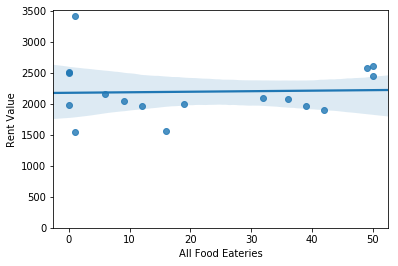

In [80]:
# Food Eateries as potential predictor variable of Rent Value

#plt.ylim(0,)

df_centralLA_SummaryAnalyse[['All Food Eateries','Rent Value']].corr()
sns.regplot(x="All Food Eateries", y="Rent Value", data=df_centralLA_SummaryAnalyse)
plt.ylim(0,)

(0, 3536.269918077146)

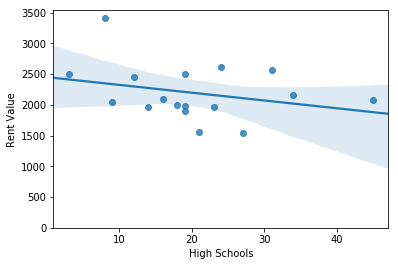

In [81]:
# Hich Schools as potential predictor variable of Rent Value

df_centralLA_SummaryAnalyse[['High Schools','Rent Value']].corr()
sns.regplot(x="High Schools", y="Rent Value", data=df_centralLA_SummaryAnalyse)
plt.ylim(0,)

In [82]:
#calculating the weightages for all central LA neighbourhoods to determine the most suitable place to open japanese restaurant

# having office complexes has a high demand for japanese food hence positive score
officeScore = 2

# high school students has a high demand for japanese food hence positive score
schoolScore =1

# university students has high demand for japanese food hence positive score
uniScore = 1

# presence of other japanese restaurants lead to poor reach hence negative score
japanScore = -3

# presence of otherfood eateries lead to poor reach hence negative score
foodScore = -2

# presence of hotels lead to high demand hence positive score
hotelScore = 2



df_centralLA_SummaryScore = df_centralLA_SummaryAnalyse[['Neighbourhood']].copy()

df_centralLA_SummaryScore['Score'] = df_centralLA_SummaryAnalyse['Office'] * officeScore + df_centralLA_SummaryAnalyse['High Schools'] * schoolScore + df_centralLA_SummaryAnalyse['All Food Eateries'] * foodScore+ df_centralLA_SummaryAnalyse['Universities'] * uniScore + df_centralLA_SummaryAnalyse['Japanese Restaurants'] * japanScore+ df_centralLA_SummaryAll['Hotels'] * hotelScore
df_centralLA_SummaryScore = df_centralLA_SummaryScore.sort_values(by=['Score'], ascending=False)
#df_centralLA_SummaryScore

df_centralLA_SummaryScoreandRent = pd.merge(df_centralLA_SummaryScore, df_CentralLA_rent, on='Neighbourhood', how='left')
df_centralLA_SummaryScoreandRent

,Neighbourhood,Score,Rent Value
0,"Hollywood Hills West, Los Angeles",100.0,"$2,498"
1,"Elysian Valley, Los Angeles",87.0,"$1,977"
2,"Elysian Park, Los Angeles",87.0,"$2,509"
3,"Echo Park, Los Angeles",84.0,"$2,156"
4,"Arlington Heights, Los Angeles",33.0,"$1,543"
5,"Silver Lake, Los Angeles",29.0,"$2,039"
6,"Windsor Square, Los Angeles",0.0,"$1,967"
7,"Carthay, Los Angeles",-27.0,"$3,410"
8,"Los Feliz, Los Angeles",-27.0,"$1,969"
9,"Harvard Heights, Los Angeles",-38.0,"$1,560"


Get All Nearby Top Attractions

In [83]:
def getNearbyVenuesAll(names, latitudes, longitudes, radius=1000):#get all nearby attraction from a given location
    LIMIT=80
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        #set the get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [84]:
df_centralLA_TopPlaces = getNearbyVenuesAll(names=central_LA_neightbourhoods_df['Neighbourhood'],
                                   latitudes=central_LA_neightbourhoods_df['Latitude'],
                                   longitudes=central_LA_neightbourhoods_df['Longitude'])

In [85]:
df_centralLA_TopPlaces.head(15)

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Arlington Heights, Los Angeles",34.128306,-118.156374,Arlington Gardens,34.128275,-118.155745,Garden
1,"Arlington Heights, Los Angeles",34.128306,-118.156374,Storrier Stearns Japanese Garden,34.127933,-118.155877,Garden
2,"Arlington Heights, Los Angeles",34.128306,-118.156374,Yoga House,34.125574,-118.150645,Yoga Studio
3,"Arlington Heights, Los Angeles",34.128306,-118.156374,1886 Bar at The Raymond,34.124379,-118.150168,Bar
4,"Arlington Heights, Los Angeles",34.128306,-118.156374,Raymond Restaurant,34.124552,-118.150038,American Restaurant
5,"Arlington Heights, Los Angeles",34.128306,-118.156374,Jones Coffee Roasters,34.133712,-118.149130,Coffee Shop
6,"Arlington Heights, Los Angeles",34.128306,-118.156374,Pie Life Pizza,34.133717,-118.149107,Pizza Place
7,"Arlington Heights, Los Angeles",34.128306,-118.156374,BevMo!,34.130553,-118.147717,Wine Shop
8,"Arlington Heights, Los Angeles",34.128306,-118.156374,Rose Tree Cottage,34.131849,-118.154288,Tea Room
9,"Arlington Heights, Los Angeles",34.128306,-118.156374,Porta Via Italian Foods,34.135832,-118.150834,Italian Restaurant


Performin one hot encoding on the top attractions by neghbourhood data frame so as to do k-mean algrothm later

In [86]:
df_centralLA_TopPlaces
df_centralLA_TopPlaces_temp = df_centralLA_TopPlaces.copy()
df_centralLA_TopPlaces_temp

# one hot encoding
df_centralLA_TopPlaces_onehot = pd.get_dummies(df_centralLA_TopPlaces_temp[['Venue Category']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
df_centralLA_TopPlaces_onehot['Neighbourhood'] = df_centralLA_TopPlaces_temp['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [df_centralLA_TopPlaces_onehot.columns[-1]] + list(df_centralLA_TopPlaces_onehot.columns[:-1])
df_centralLA_TopPlaces_onehot = df_centralLA_TopPlaces_onehot[fixed_columns]

df_centralLA_TopPlaces_grouped = df_centralLA_TopPlaces_onehot.groupby('Neighbourhood').mean().reset_index()
df_centralLA_TopPlaces_grouped

,Neighbourhood,ATM,Accessories Store,Airport,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Train Station,Travel Lounge,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Arlington Heights, Los Angeles",0.000000,0.000000,0.000000,0.024390,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,0.0000,0.0000,0.000000,0.0000,0.000000,0.02439,0.02439,0.000,0.048780
1,"Carthay, Los Angeles",0.000000,0.000000,0.000000,0.000000,0.0125,0.0000,0.0000,0.0000,0.0250,...,0.000,0.0000,0.0000,0.012500,0.0125,0.000000,0.00000,0.00000,0.000,0.012500
2,"Chinatown, Los Angeles",0.000000,0.000000,0.000000,0.000000,0.0000,0.0500,0.0125,0.0000,0.0125,...,0.025,0.0125,0.0000,0.000000,0.0250,0.000000,0.00000,0.00000,0.000,0.000000
3,"East Hollywood, Los Angeles",0.000000,0.000000,0.000000,0.012500,0.0000,0.0125,0.0000,0.0000,0.0250,...,0.000,0.0000,0.0375,0.000000,0.0000,0.000000,0.01250,0.01250,0.000,0.025000
4,"Echo Park, Los Angeles",0.000000,0.000000,0.000000,0.025000,0.0125,0.0250,0.0125,0.0125,0.0125,...,0.000,0.0000,0.0250,0.000000,0.0000,0.012500,0.00000,0.00000,0.000,0.000000
5,"Elysian Park, Los Angeles",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,0.0000,0.0000,0.000000,0.0000,0.000000,0.00000,0.00000,0.000,0.000000
6,"Elysian Valley, Los Angeles",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,0.0000,0.0000,0.000000,0.0000,0.000000,0.00000,0.00000,0.000,0.000000
7,"Hancock Park, Los Angeles",0.000000,0.000000,0.000000,0.012500,0.0000,0.0500,0.1000,0.0000,0.0000,...,0.000,0.0000,0.0000,0.000000,0.0125,0.000000,0.00000,0.00000,0.025,0.000000
8,"Harvard Heights, Los Angeles",0.000000,0.000000,0.000000,0.012500,0.0125,0.0250,0.0000,0.0000,0.0125,...,0.000,0.0000,0.0000,0.037500,0.0125,0.000000,0.00000,0.00000,0.000,0.000000
9,"Hollywood Hills West, Los Angeles",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,0.0000,0.0000,0.000000,0.0000,0.000000,0.00000,0.00000,0.000,0.000000


Returns the most visited category of venues (Top 5) for each neighbourhood

In [87]:
def return_most_visited_venues(row, num_top_venues):#function to capture most visited place of a neighbourhood
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending=False)
    
    return row_cat_sorted.index.values[0:num_top_venues]

num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number venuss
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))#append the columns
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
#add a new datafrane
df_centralLA_TopPlaces_sorted = pd.DataFrame(columns=columns)
df_centralLA_TopPlaces_sorted['Neighbourhood'] = df_centralLA_TopPlaces_grouped['Neighbourhood']

for ind in np.arange(df_centralLA_TopPlaces_grouped.shape[0]):
    df_centralLA_TopPlaces_sorted.iloc[ind, 1:] = return_most_visited_venues(df_centralLA_TopPlaces_grouped.iloc[ind, :], num_top_venues)

df_centralLA_TopPlaces_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Arlington Heights, Los Angeles",Gym,Coffee Shop,Sandwich Place,Garden,Gym / Fitness Center
1,"Carthay, Los Angeles",Ethiopian Restaurant,Grocery Store,Mobile Phone Shop,Rental Car Location,Middle Eastern Restaurant
2,"Chinatown, Los Angeles",Chinese Restaurant,Bakery,Art Gallery,Coffee Shop,Sandwich Place
3,"East Hollywood, Los Angeles",Coffee Shop,Bar,Pizza Place,Food Truck,Vegetarian / Vegan Restaurant
4,"Echo Park, Los Angeles",Café,Mexican Restaurant,Coffee Shop,Bar,Pizza Place
5,"Elysian Park, Los Angeles",Park,Trail,Intersection,Scenic Lookout,Food Truck
6,"Elysian Valley, Los Angeles",Park,Trail,Intersection,Scenic Lookout,Food Truck
7,"Hancock Park, Los Angeles",Art Museum,Museum,Coffee Shop,Art Gallery,Gym
8,"Harvard Heights, Los Angeles",Coffee Shop,Fast Food Restaurant,Grocery Store,Sandwich Place,Mexican Restaurant
9,"Hollywood Hills West, Los Angeles",Trail,Park,Convenience Store,Marijuana Dispensary,Mountain


Performing K-mean Clustering

In [47]:
from sklearn.cluster import KMeans

kclusters = 7# set number of clusters
df_centralLA_TopPlaces_clustering = df_centralLA_TopPlaces_grouped.drop('Neighbourhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_centralLA_TopPlaces_clustering)#run k means clustering

# check cluster labels generated
kmeans.labels_[0:10]

array([3, 5, 6, 3, 3, 2, 2, 0, 5, 4], dtype=int32)

In [48]:
central_LA_neightbourhoods_Cluster = central_LA_neightbourhoods_df.copy()
central_LA_neightbourhoods_Cluster['Cluster Labels'] = kmeans.labels_

# merge Neighborhoods dataframe with LA borough dataframe to add latitude/longitude for each neighborhood
central_LA_neightbourhoods_Cluster = central_LA_neightbourhoods_Cluster.join(df_centralLA_TopPlaces_sorted.set_index('Neighbourhood'), on='Neighbourhood')


central_LA_neightbourhoods_Cluster

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Arlington Heights, Los Angeles",34.1283,-118.156,3,Gym,Coffee Shop,Sandwich Place,Garden,Gym / Fitness Center
1,"Carthay, Los Angeles",34.0561,-118.373,5,Ethiopian Restaurant,Grocery Store,Mobile Phone Shop,Rental Car Location,Middle Eastern Restaurant
2,"Chinatown, Los Angeles",34.0635,-118.236,6,Chinese Restaurant,Bakery,Art Gallery,Coffee Shop,Sandwich Place
3,"East Hollywood, Los Angeles",34.0932,-118.32,3,Coffee Shop,Bar,Pizza Place,Food Truck,Vegetarian / Vegan Restaurant
4,"Echo Park, Los Angeles",34.074,-118.261,3,Café,Mexican Restaurant,Coffee Shop,Bar,Pizza Place
5,"Elysian Park, Los Angeles",34.0829,-118.234,2,Park,Trail,Intersection,Scenic Lookout,Food Truck
6,"Elysian Valley, Los Angeles",34.0829,-118.234,2,Park,Trail,Intersection,Scenic Lookout,Food Truck
7,"Hancock Park, Los Angeles",34.0637,-118.356,0,Art Museum,Museum,Coffee Shop,Art Gallery,Gym
8,"Harvard Heights, Los Angeles",34.0724,-118.288,5,Coffee Shop,Fast Food Restaurant,Grocery Store,Sandwich Place,Mexican Restaurant
9,"Hollywood Hills West, Los Angeles",34.1312,-118.336,4,Trail,Park,Convenience Store,Marijuana Dispensary,Mountain


Plotting Graph with Clusters generated from K-Mean Algorithm

In [49]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
y = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(y)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(central_LA_neightbourhoods_Cluster['Latitude'], central_LA_neightbourhoods_Cluster['Longitude'], central_LA_neightbourhoods_Cluster['Neighbourhood'], central_LA_neightbourhoods_Cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

Finding which entries belong to which cluster after K-Means Clustering

In [50]:
central_LA_neightbourhoods_Cluster.loc[central_LA_neightbourhoods_Cluster['Cluster Labels'] == 0, central_LA_neightbourhoods_Cluster.columns[[0]+[4] + list(range(5, central_LA_neightbourhoods_Cluster.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,"Hancock Park, Los Angeles",Art Museum,Museum,Coffee Shop,Art Gallery,Gym
11,"Larchmont, Los Angeles",Coffee Shop,Italian Restaurant,Mexican Restaurant,Bakery,Restaurant
12,"Los Feliz, Los Angeles",Coffee Shop,Italian Restaurant,Mediterranean Restaurant,Ice Cream Shop,Breakfast Spot
15,"Silver Lake, Los Angeles",Coffee Shop,Ice Cream Shop,American Restaurant,Breakfast Spot,Pizza Place
17,"Windsor Square, Los Angeles",Coffee Shop,Spa,Juice Bar,Bakery,Italian Restaurant


In [51]:
central_LA_neightbourhoods_Cluster.loc[central_LA_neightbourhoods_Cluster['Cluster Labels'] == 1, central_LA_neightbourhoods_Cluster.columns[[0]+[4] + list(range(5, central_LA_neightbourhoods_Cluster.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,"Koreatown, Los Angeles",Korean Restaurant,Coffee Shop,Café,Mexican Restaurant,Seafood Restaurant
13,"Mid-Wilshire, Los Angeles",Korean Restaurant,Japanese Restaurant,Bakery,Restaurant,Ice Cream Shop


In [52]:
central_LA_neightbourhoods_Cluster.loc[central_LA_neightbourhoods_Cluster['Cluster Labels'] == 2, central_LA_neightbourhoods_Cluster.columns[[0]+[4] + list(range(5, central_LA_neightbourhoods_Cluster.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,"Elysian Park, Los Angeles",Park,Trail,Intersection,Scenic Lookout,Food Truck
6,"Elysian Valley, Los Angeles",Park,Trail,Intersection,Scenic Lookout,Food Truck


In [53]:
central_LA_neightbourhoods_Cluster.loc[central_LA_neightbourhoods_Cluster['Cluster Labels'] == 3, central_LA_neightbourhoods_Cluster.columns[[0]+[4] + list(range(5, central_LA_neightbourhoods_Cluster.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Arlington Heights, Los Angeles",Gym,Coffee Shop,Sandwich Place,Garden,Gym / Fitness Center
3,"East Hollywood, Los Angeles",Coffee Shop,Bar,Pizza Place,Food Truck,Vegetarian / Vegan Restaurant
4,"Echo Park, Los Angeles",Café,Mexican Restaurant,Coffee Shop,Bar,Pizza Place


In [54]:
central_LA_neightbourhoods_Cluster.loc[central_LA_neightbourhoods_Cluster['Cluster Labels'] == 4, central_LA_neightbourhoods_Cluster.columns[[0]+[4] + list(range(5, central_LA_neightbourhoods_Cluster.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,"Hollywood Hills West, Los Angeles",Trail,Park,Convenience Store,Marijuana Dispensary,Mountain


In [55]:
central_LA_neightbourhoods_Cluster.loc[central_LA_neightbourhoods_Cluster['Cluster Labels'] == 5, central_LA_neightbourhoods_Cluster.columns[[0]+[4] + list(range(5, central_LA_neightbourhoods_Cluster.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,"Carthay, Los Angeles",Ethiopian Restaurant,Grocery Store,Mobile Phone Shop,Rental Car Location,Middle Eastern Restaurant
8,"Harvard Heights, Los Angeles",Coffee Shop,Fast Food Restaurant,Grocery Store,Sandwich Place,Mexican Restaurant
14,"Pico-Union, Los Angeles",Mexican Restaurant,Pizza Place,Fast Food Restaurant,Latin American Restaurant,Pharmacy
16,"Westlake, Los Angeles",Fast Food Restaurant,Latin American Restaurant,Sandwich Place,Korean Restaurant,Coffee Shop


In [56]:
central_LA_neightbourhoods_Cluster.loc[central_LA_neightbourhoods_Cluster['Cluster Labels'] == 6, central_LA_neightbourhoods_Cluster.columns[[0]+[4] + list(range(5, central_LA_neightbourhoods_Cluster.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,"Chinatown, Los Angeles",Chinese Restaurant,Bakery,Art Gallery,Coffee Shop,Sandwich Place
